In [1]:
%matplotlib inline

In [2]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pandas as pd

out_dir = "/storage/data/DSB2018/phase-2-imgs/"

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Load annotations in Kyle's set

In [3]:
kyle_img_dir = "/storage/data/DSB2018/Kyle_stage2/"
kyle_imgs = []

for imn in tqdm(os.listdir(kyle_img_dir)):
    data = skimage.io.imread_collection(kyle_img_dir + imn + "/masks/*.png")
    labels = np.zeros(data[0].shape, dtype=np.int16)
    for i in range(len(data)):
        labels[data[i] > 0] = i + 1
    kyle_imgs.append({"key":imn, "im":labels})

100%|██████████| 106/106 [00:03<00:00, 32.00it/s]


# Load ground truth in Allen's set

In [4]:
allen_img_dir = "/storage/data/DSB2018/phase-2-gt/"
allen_imgs = []

for imn in tqdm(os.listdir(allen_img_dir)):
    labels = skimage.io.imread(allen_img_dir + imn)
    allen_imgs.append({"key":imn.replace(".png", ""), "im":labels})

100%|██████████| 106/106 [00:00<00:00, 770.66it/s]


# Match annotations using L1-pixelwise distance

In [5]:
sim_matrix = np.zeros((len(kyle_imgs), len(allen_imgs)))
for i in tqdm(range(len(kyle_imgs))):
    for j in range(len(allen_imgs)):
        A = (kyle_imgs[i]["im"] > 0).astype(np.int8)
        B = (allen_imgs[j]["im"] > 0).astype(np.int8)
        if kyle_imgs[i]["im"].shape == allen_imgs[j]["im"].shape:
            sim_matrix[i,j] = np.sum(np.abs(A - B))
        else:
            sim_matrix[i,j] = np.sum(A) + np.sum(B)
    

100%|██████████| 106/106 [00:06<00:00, 16.88it/s]


# Extract the top matches and check no 

In [6]:
matches = np.argsort(sim_matrix, axis=1)[:,0]
assert len(np.unique(matches)) == len(kyle_imgs)

In [7]:
matched_names = []
for i in range(len(matches)):
    matched_names.append({
        "kyle_id": i,
        "kyle":kyle_imgs[i]["key"], 
        "allen_id": matches[i],
        "allen":allen_imgs[matches[i]]["key"]}
    )

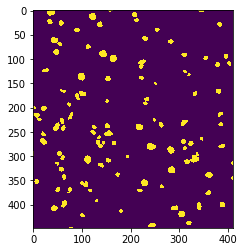

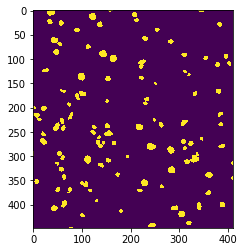

In [8]:
m = matched_names[0]
plt.figure()
plt.imshow(kyle_imgs[m["kyle_id"]]["im"] > 0)
plt.figure()
plt.imshow(allen_imgs[m["allen_id"]]["im"] > 0)

In [9]:
df = pd.DataFrame(data=matched_names)
df = df[["allen", "kyle"]]
df.to_csv("/storage/data/DSB2018/metadata/matched_names.csv", index=False)

In [10]:
for d in tqdm(df.iterrows()):
    source = os.listdir(kyle_img_dir + d[1]["kyle"] + "/images/")
    if len(source) > 1:
        print("Problem with:", d[1]["kyle"])
    source = kyle_img_dir + d[1]["kyle"] + "/images/" + source[0]
    destination = out_dir + d[1]["allen"] + ".png"
    os.system("cp " + source + " " + destination)

106it [00:00, 126.32it/s]
